In [1]:
import pickle
import numpy as np
import random
import glob
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as func
from torchvision.models import resnet18
from torchvision import transforms, models
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import entropy
from getData import *
from trainer import *
from getModel import *
#import torchprofile

import time
import pandas as pd
# Seed for reproducibility
SEED = 25
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

C:\Users\rafor\anaconda3\envs\endg511\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


cuda:0


# **Load Dataset**

In [2]:
dataset = TrainValDataset()
trainval_size = int(0.8 * len(dataset))
test_size = len(dataset) - trainval_size

trainval_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainval_size, test_size])

train_size = int(0.75 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)

val_loader = DataLoader(val_dataset, batch_size= 32, shuffle = False, num_workers= 0)

test_loader = DataLoader(test_dataset, batch_size= 32, shuffle = False, num_workers= 0)


['Training\\Fire', 'Training\\No_Fire']


# **Baseline Model**

In [3]:
NUM_EPOCHS = 10

In [4]:
blNet = blModel().to(device)
optimizer_bl = optim.Adam(blNet.parameters(), lr=1e-3)
scheduler = None
criterion_bl = nn.CrossEntropyLoss()

In [5]:
summary(blNet, (3, 254, 254))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 254, 254]             112
       BatchNorm2d-2          [-1, 4, 254, 254]               8
              ReLU-3          [-1, 4, 254, 254]               0
            Conv2d-4          [-1, 4, 254, 254]             148
       BatchNorm2d-5          [-1, 4, 254, 254]               8
              ReLU-6          [-1, 4, 254, 254]               0
         MaxPool2d-7          [-1, 4, 127, 127]               0
            Conv2d-8          [-1, 8, 127, 127]             296
       BatchNorm2d-9          [-1, 8, 127, 127]              16
             ReLU-10          [-1, 8, 127, 127]               0
           Conv2d-11          [-1, 8, 127, 127]             584
      BatchNorm2d-12          [-1, 8, 127, 127]              16
             ReLU-13          [-1, 8, 127, 127]               0
        MaxPool2d-14            [-1, 8,

In [6]:
bl_titleToday = "./Models/best_bl_0319.pth"
BL = blHandler(blNet, criterion_bl, optimizer_bl, device=device, scheduler=scheduler, num_epochs=NUM_EPOCHS, bestPath=bl_titleToday)
blNet, blHistory = BL.train(train_loader, val_loader)

epoch 1 --> trainLoss: 0.358, trainAcc: 0.954, validLoss: 0.331, validAcc: 0.982
Model Saved!
epoch 2 --> trainLoss: 0.336, trainAcc: 0.977, validLoss: 0.329, validAcc: 0.985
Model Saved!
epoch 3 --> trainLoss: 0.332, trainAcc: 0.981, validLoss: 0.350, validAcc: 0.963
epoch 4 --> trainLoss: 0.330, trainAcc: 0.983, validLoss: 0.335, validAcc: 0.978
epoch 5 --> trainLoss: 0.329, trainAcc: 0.984, validLoss: 0.327, validAcc: 0.986
Model Saved!
epoch 6 --> trainLoss: 0.328, trainAcc: 0.985, validLoss: 0.327, validAcc: 0.986
epoch 7 --> trainLoss: 0.327, trainAcc: 0.986, validLoss: 0.325, validAcc: 0.988
Model Saved!
epoch 8 --> trainLoss: 0.326, trainAcc: 0.987, validLoss: 0.323, validAcc: 0.990
Model Saved!
epoch 9 --> trainLoss: 0.324, trainAcc: 0.989, validLoss: 0.323, validAcc: 0.990
Model Saved!
epoch 10 --> trainLoss: 0.324, trainAcc: 0.989, validLoss: 0.322, validAcc: 0.991
Model Saved!


In [28]:
bl_titleToday = "./Models/best_bl_0319.pth"
blNet.load_state_dict(torch.load("./Models/best_bl_0319.pth"))
BL = blHandler(blNet, criterion_bl, optimizer_bl, device=device, scheduler=scheduler, num_epochs=NUM_EPOCHS, bestPath=bl_titleToday)
startTime = time.time()
predicted, acc = BL.infer(test_loader)
executionTime= (time.time() - startTime)/len(predicted)

In [29]:
print(acc)
print(executionTime)

0.9930208333333334
0.0015910915663272394


# **EE Model**

In [9]:
dataset = TrainValDataset()
trainval_size = int(0.8 * len(dataset))
test_size = len(dataset) - trainval_size

trainval_dataset, test_dataset = torch.utils.data.random_split(dataset, [trainval_size, test_size])

train_size = int(0.75 * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size= 32, shuffle = True, num_workers= 0)

val_loader = DataLoader(val_dataset, batch_size= 32, shuffle = False, num_workers= 0)

test_loader = DataLoader(test_dataset, batch_size= 32, shuffle = False, num_workers= 0)

['Training\\Fire', 'Training\\No_Fire']


In [10]:
NUM_EPOCHS = 10

In [11]:
eeNet_V0 = eeModel_V0().to(device)
optimizer_ee_V0 = optim.Adam(eeNet_V0.parameters(), lr=1e-3)
scheduler_V0 = None
criterion_ee_V0 = nn.CrossEntropyLoss()
V0_titleToday = "./Models/best_eev0.pth"
EE_V0 = eeHandler(eeNet_V0, criterion_ee_V0, optimizer_ee_V0, device=device, scheduler=scheduler_V0, num_epochs=NUM_EPOCHS, bestPath=V0_titleToday)

Number of base parameters: 1188
Number of short branch parameters: 8402434
Number of long branch parameters: 16280850
Difference = 7878416


In [12]:
eeNetV0, eeV0History = EE_V0.train(train_loader, val_loader)

epoch 1 --> trainLoss: 0.369, trainAcc: 0.944, validLoss: 0.349, validAcc: 0.964
Model Saved!
epoch 2 --> trainLoss: 0.346, trainAcc: 0.967, validLoss: 0.339, validAcc: 0.973
Model Saved!
epoch 3 --> trainLoss: 0.340, trainAcc: 0.973, validLoss: 0.331, validAcc: 0.982
Model Saved!
epoch 4 --> trainLoss: 0.336, trainAcc: 0.977, validLoss: 0.328, validAcc: 0.985
Model Saved!
epoch 5 --> trainLoss: 0.332, trainAcc: 0.980, validLoss: 0.326, validAcc: 0.987
Model Saved!
epoch 6 --> trainLoss: 0.329, trainAcc: 0.984, validLoss: 0.322, validAcc: 0.991
Model Saved!
epoch 7 --> trainLoss: 0.327, trainAcc: 0.986, validLoss: 0.322, validAcc: 0.991
Model Saved!
epoch 8 --> trainLoss: 0.325, trainAcc: 0.988, validLoss: 0.320, validAcc: 0.993
Model Saved!
epoch 9 --> trainLoss: 0.324, trainAcc: 0.989, validLoss: 0.321, validAcc: 0.993
epoch 10 --> trainLoss: 0.323, trainAcc: 0.990, validLoss: 0.325, validAcc: 0.989


In [13]:
V0_titleToday = "./Models/best_eev0.pth"
eeNet_V0.load_state_dict(torch.load("./Models/best_eev0.pth"))
EE_V0 = eeHandler(eeNet_V0, criterion_ee_V0, optimizer_ee_V0, device=device, scheduler=scheduler_V0, num_epochs=NUM_EPOCHS, bestPath=V0_titleToday)

Threshold = 0.05

In [14]:
rec, pred1, acc = EE_V0.infer(test_loader, threshold = 0.05)
EE_V0.testingSummary(rec)

Summary
Branch 1: Accuracy 99.23% with 99.27% of the samples
Branch 2: Accuracy 90.00% with 0.73% of the samples
Overall Weighted Accuracy: 99.17%


In [18]:
startTime = time.time()
EE_V0.forward_timeTest(test_loader, ratio = 0.9927)
executionTime= (time.time() - startTime)/len(test_dataset)
print(executionTime)

0.001179737179884626


Threshold = 0.1

In [15]:
rec, pred2, acc = EE_V0.infer(test_loader, threshold = 0.1)
EE_V0.testingSummary(rec)

Summary
Branch 1: Accuracy 99.23% with 99.55% of the samples
Branch 2: Accuracy 88.37% with 0.45% of the samples
Overall Weighted Accuracy: 99.18%


In [19]:
startTime = time.time()
EE_V0.forward_timeTest(test_loader, ratio = 0.9955)
executionTime= (time.time() - startTime)/len(test_dataset)
print(executionTime)

0.0011725422491293573


Threshold = 0.2

In [16]:
rec, pred3, acc = EE_V0.infer(test_loader, threshold = 0.2)
EE_V0.testingSummary(rec)

Summary
Branch 1: Accuracy 99.16% with 99.74% of the samples
Branch 2: Accuracy 88.00% with 0.26% of the samples
Overall Weighted Accuracy: 99.14%


In [20]:
startTime = time.time()
EE_V0.forward_timeTest(test_loader, ratio = 0.9974)
executionTime= (time.time() - startTime)/len(test_dataset)
print(executionTime)

0.0011702483737825143


In [21]:
eeNet_V0.compute_size()

94.18785858154297

# **Plots**

In [22]:
idx = range(len(test_dataset))
true_label = []
for inputs, labels in test_loader:
        
        labels = labels.data.cpu().float().tolist()
        true_label.extend(labels) # Save Truth


In [23]:
for i in range(len(true_label)):
    true_label[i] = int(true_label[i][0])

**BL Plots**

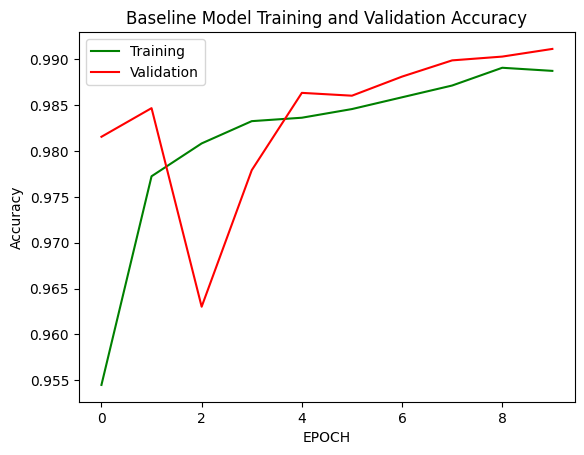

In [24]:
figTitle = './Figures/BL_tv_acc.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, blHistory["train"]["accuracy"], color = "green");
plt.plot(xAxis, blHistory["validation"]["accuracy"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.title("Baseline Model Training and Validation Accuracy")
plt.savefig(figTitle)
plt.show()

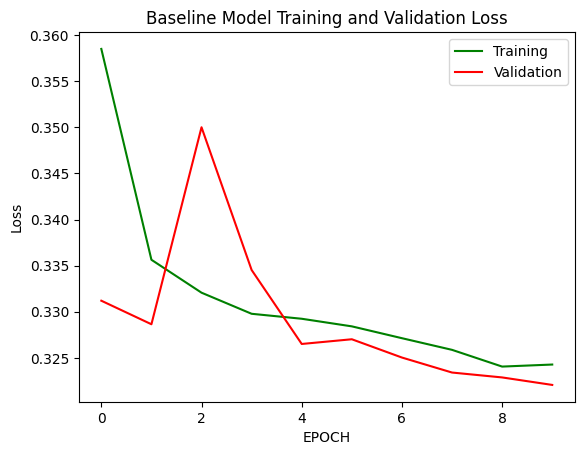

In [25]:
figTitle = './Figures/BL_tv_loss.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, blHistory["train"]["loss"], color = "green");
plt.plot(xAxis, blHistory["validation"]["loss"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title("Baseline Model Training and Validation Loss")
plt.savefig(figTitle)
plt.show()

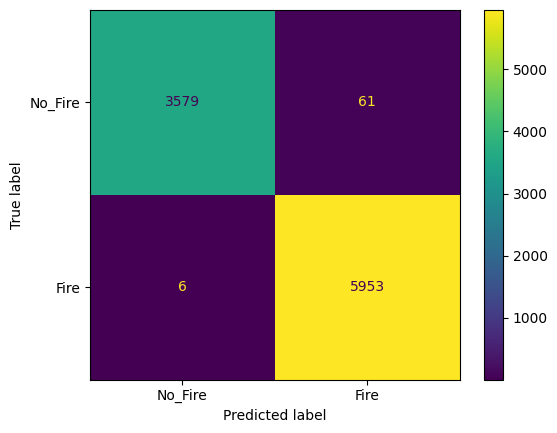

In [30]:
cfm = confusion_matrix(true_label, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()

**Early Exiting Plots**

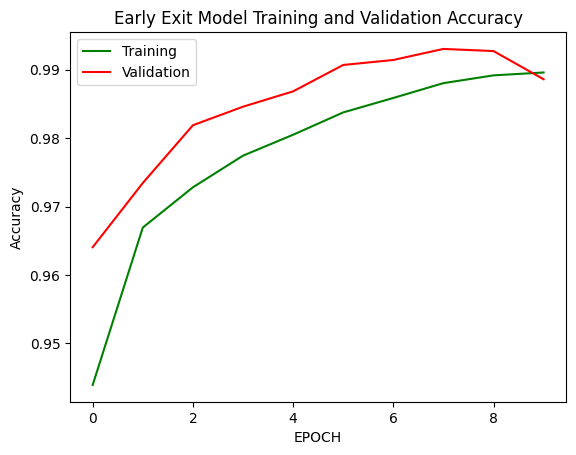

In [31]:
figTitle = './Figures/EE0_tv_acc.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, eeV0History['T']["train"]["accuracy"], color = "green");
plt.plot(xAxis, eeV0History['T']["validation"]["accuracy"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.title("Early Exit Model Training and Validation Accuracy")
plt.savefig(figTitle)
plt.show()

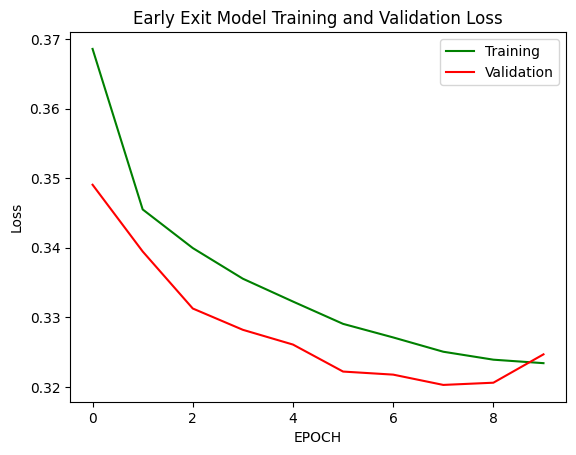

In [32]:
figTitle = './Figures/EE0_tv_loss.png'
fig = plt.Figure()
xAxis = range(10)

plt.plot(xAxis, eeV0History['T']["train"]["loss"], color = "green");
plt.plot(xAxis, eeV0History['T']["validation"]["loss"], color = "red");
plt.legend(["Training", "Validation"])
plt.xlabel('EPOCH')
plt.ylabel('Loss')
plt.title("Early Exit Model Training and Validation Loss")
plt.savefig(figTitle)
plt.show()

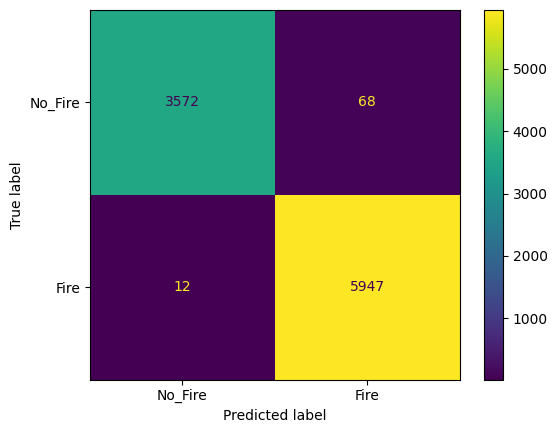

In [33]:
cfm = confusion_matrix(true_label, pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()

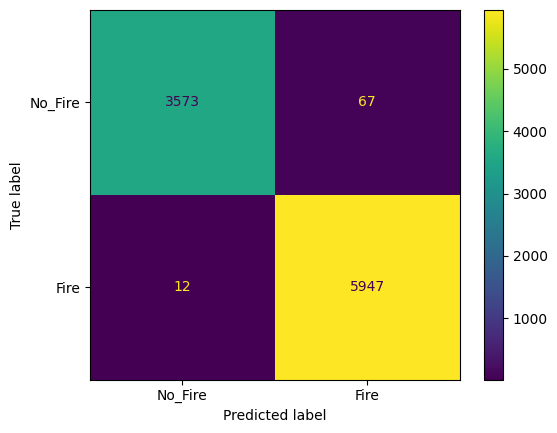

In [34]:
cfm = confusion_matrix(true_label, pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()

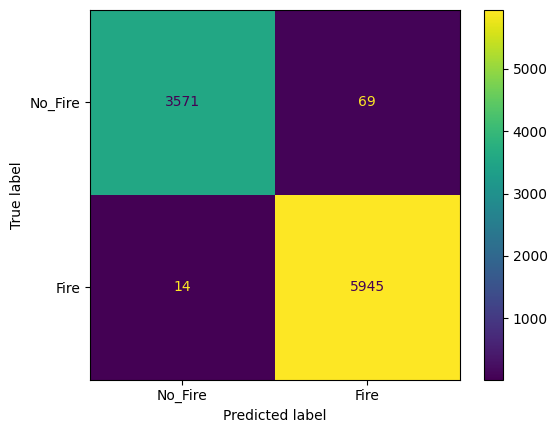

In [35]:
cfm = confusion_matrix(true_label, pred3)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=["No_Fire","Fire"])
disp.plot()